In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import pylab as pl
from numpy import fft
import datetime as dt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load the fact table
filepath_fact = '/content/drive/My Drive/Datathon Term 3/Data/A9002SE2REVSFF_fact_data_05132020.csv'
fact = pd.read_csv(filepath_fact, sep = '|') 

# load dimension table with foreign key MKT_TAG
filepath_dim_mkt = '/content/drive/My Drive/Datathon Term 3/Data/A9002SE2REVSFF_MKT_05132020.csv'
dim_mkt_tag = pd.read_csv(filepath_dim_mkt, sep = '|')

# drop columns with only NAs
dim_mkt_tag.drop(['PARENT_TAG',	'HIER_NUM',	'HIER_NAME',	'HIER_LEVEL_NUM',	'HIER_LEVEL_NAME'],
                 axis = 1,
                 inplace = True)

# load dimension table with foreign key PROD_TAG
filepath_dim_prod = '/content/drive/My Drive/Datathon Term 3/Data/A9002SE2REVSFF_PROD_05132020.csv'
dim_prod_tag = pd.read_csv(filepath_dim_prod, sep = '|')

# load dimension table with foreign key PER_TAG
filepath_dim_per = '/content/drive/My Drive/Datathon Term 3/Data/A9002SE2REVSFF_PER_05132020.csv'
dim_per_tag = pd.read_csv(filepath_dim_per, sep = '|')

# drop columns with only NAs
dim_per_tag.drop(['PARENT_TAG',	'HIER_NUM',	'HIER_NAME',	'HIER_LEVEL_NUM',	'HIER_LEVEL_NAME'],
                 axis = 1,
                 inplace = True)

# load metadata table for names of column of the fact table
filepath_col_desc = '/content/drive/My Drive/Datathon Term 3/Data/A9002SE2REVSFF_FCT_05132020.csv'
fact_col_desc = pd.read_csv(filepath_col_desc, sep = '|')

# merge data
fact = fact.merge(dim_per_tag, left_on='PER_TAG', right_on='TAG', suffixes=('', '_PER'))
fact = fact.merge(dim_prod_tag, left_on='PROD_TAG', right_on='TAG', suffixes = ('', '_PROD'))

# get date in datetime format
fact['DATE'] = fact.LONG.map(lambda string: dt.datetime.strptime(string[14:22], '%d-%m-%y'))

# reshape to table to have market and hierarchy level on a column multi-index
volume = fact.pivot_table(values = 'E', index = 'DATE', columns = ['MKT_TAG', 'SECTOR', 'SECCION', 'CATEGORIA', 'FAMILIA', 'TIPO DE MARCA'])

# remove impact of Covid-19 and replace with average from the two previous years
third_week_march = volume.loc[(volume.index == '2018-03-18') | (volume.index == '2019-03-17'),:].apply('mean')
fourth_week_march = volume.loc[(volume.index == '2018-03-25') | (volume.index == '2019-03-24'),:].apply('mean')

volume.loc[volume.index == '2020-03-15',:] = np.array(third_week_march)
volume.loc[volume.index == '2020-03-22',:] = np.array(fourth_week_march)

# print shape and first 5 rows
print(f'Shape of volume dataframe: {volume.shape}\n\n')
volume.head()

Shape of volume dataframe: (160, 29887)




MKT_TAG                 MTHO7            ...                  MULSC        
SECTOR        ALIM. Y BEBIDAS            ...           PROD.FRESCOS        
SECCION             ALIM.SECA            ...                 QUESOS        
CATEGORIA              ACEITE            ... RESTO QUESOS NATURALES        
FAMILIA             GIRASOL..            ...        RQN.EMPAQUETADO        
TIPO DE MARCA            M.D.      M.F.  ...                   M.D.    M.F.
DATE                                     ...                               
2017-04-16           284826.0   84454.0  ...                  918.0  1289.0
2017-04-23           256410.0   80760.0  ...                  809.0   897.0
2017-04-30           297632.0  101413.0  ...                  883.0  1107.0
2017-05-07           271115.0   94962.0  ...                  774.0   813.0
2017-05-14           261788.0   90573.0  ...                  816.0   900.0

[5 rows x 29887 columns]

In [ ]:
# load the analytical base table
features = pd.read_csv('/content/drive/My Drive/Datathon Term 3/Data/analytical_base_table.csv', index_col = 'DATE')
features

,day,week,month,season,holiday,oil_price,quarterly_unemployment_rate,quarterly_gdp_growth_rate,quarterly_inflation_rate
DATE,,,,,,,,,
2017-04-16,16,15,4,spring,True,51.06,17.535688,3.077982,1.841017
2017-04-23,23,16,4,spring,False,51.06,17.496519,3.077982,1.841017
2017-04-30,30,17,4,spring,False,51.06,17.457350,3.077982,1.841017
2017-05-07,7,18,5,spring,True,48.48,17.418181,3.077982,1.841017
2017-05-14,14,19,5,spring,False,48.48,17.379012,3.077982,1.841017
...,...,...,...,...,...,...,...,...,...
2020-11-29,29,48,11,fall,False,34.50,14.941758,3.881060,-0.374563
2020-12-06,6,49,12,fall,True,35.00,14.941758,3.881060,-0.374563
2020-12-13,13,50,12,fall,True,35.00,14.941758,3.881060,-0.374563


In [ ]:
def fourierExtrapolation(x, n_predict):
    n = x.size
    n_harm = 5                     # number of harmonics in model
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
    f = fft.fftfreq(n)              # frequencies
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    # indexes.sort(key = lambda i: np.absolute(f[i]))
    indexes.sort(key=lambda i: np.absolute(x_freqdom[i]))
    indexes.reverse()
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

In [ ]:
def predict(market, hierarchy_level, hierarchy_name, prediction_horizon):

  # define a boolean mask based on market and hierarchy level
  mask = (volume.columns.get_level_values(0) == market) & (volume.columns.get_level_values(hierarchy_level) == hierarchy_name)

  # create get the time series for the specified market and hierarchy level combination
  product = volume.iloc[:,mask].apply('sum', axis = 1)

  if prediction_horizon == 'pre_covid':
    train_date = '2019-07-01'
    test_date = '2020-01-01'
  elif prediction_horizon == 'during_covid':
    train_date = '2020-01-01'
    test_date = '2020-05-05'

  # create a feature using fourier transformation
  n_predict = features.shape[0] - product.loc[product.index < train_date].shape[0]
  features['fourier_transform'] = fourierExtrapolation(x = product.loc[product.index < train_date].to_numpy(), 
                                                       n_predict = n_predict)

  # create X_train and y_train as all data before Q3 2019
  X_train = features.loc[features.index < train_date,:].copy()
  y_train = product.loc[product.index < train_date].copy()

  # create X_test and y_test all data data in Q3 & Q4 2019
  X_test = features.loc[(features.index >= train_date) & (features.index < test_date),:].copy()
  y_test = product.loc[(product.index >= train_date) & (product.index < test_date)].copy()

  # create and fit a model
  preprocessing = make_column_transformer((OneHotEncoder(), ['season']), remainder = 'passthrough')
  model = make_pipeline(preprocessing, RandomForestRegressor(min_samples_leaf = 5, n_estimators = 1000, random_state = 12))
  model.fit(X_train, y_train)

  # predict on train and test set
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  # evaluate model
  r2_train = r2_score(y_train, y_train_pred)
  mape_train = 100 * np.mean(abs(y_train - y_train_pred) / y_train)

  r2_test = r2_score(y_test, y_test_pred)
  mape_test = 100 * np.mean(abs(y_test - y_test_pred) / y_test)

  r2_test_4 = r2_score(y_test[:4], y_test_pred[:4])
  mape_test_4 = 100 * np.mean(abs(y_test[:4] - y_test_pred[:4]) / y_test[:4])

  # return results
  return r2_train, mape_train, r2_test, mape_test, r2_test_4, mape_test_4

In [ ]:
model_evaluation_df = pd.DataFrame(fact.SECCION.unique(), columns=['sections']).dropna()
for section in model_evaluation_df.sections:

  # make predictions for pre-covid
  r2_train, mape_train, r2_test, mape_test, r2_test_4, mape_test_4 = predict('MTHO7', 2, section, 'pre_covid')
  model_evaluation_df.loc[model_evaluation_df.sections == section, 'r2_train_pre_covid'] = r2_train
  model_evaluation_df.loc[model_evaluation_df.sections == section, 'mape_train_pre_covid'] = mape_train
  model_evaluation_df.loc[model_evaluation_df.sections == section, 'r2_test_pre_covid'] = r2_test
  model_evaluation_df.loc[model_evaluation_df.sections == section, 'mape_test_pre_covid'] = mape_test
  model_evaluation_df.loc[model_evaluation_df.sections == section, 'r2_test_4_pre_covid'] = r2_test_4
  model_evaluation_df.loc[model_evaluation_df.sections == section, 'mape_test_4_pre_covid'] = mape_test_4

  # make predictiosn for during-covid
  r2_train, mape_train, r2_test, mape_test, r2_test_4, mape_test_4 = predict('MTHO7', 2, section, 'during_covid')
  model_evaluation_df.loc[model_evaluation_df.sections == section, 'r2_train_during_covid'] = r2_train
  model_evaluation_df.loc[model_evaluation_df.sections == section, 'mape_train_during_covid'] = mape_train
  model_evaluation_df.loc[model_evaluation_df.sections == section, 'r2_test_during_covid'] = r2_test
  model_evaluation_df.loc[model_evaluation_df.sections == section, 'mape_test_during_covid'] = mape_test
  model_evaluation_df.loc[model_evaluation_df.sections == section, 'r2_test_4_during_covid'] = r2_test_4
  model_evaluation_df.loc[model_evaluation_df.sections == section, 'mape_test_4_during_covid'] = mape_test_4

model_evaluation_df

,sections,r2_train_pre_covid,mape_train_pre_covid,r2_test_pre_covid,mape_test_pre_covid,r2_test_4_pre_covid,mape_test_4_pre_covid,r2_train_during_covid,mape_train_during_covid,r2_test_during_covid,mape_test_during_covid,r2_test_4_during_covid,mape_test_4_during_covid
1,ALIM.SECA,0.732380,2.417682,0.608991,3.301435,0.495125,1.638604,0.755093,2.143771,-1.001335,8.758327,-0.425960,2.847521
2,BEBIDAS,0.915833,2.685068,-0.231526,13.634778,-81.269523,18.617959,0.927661,2.599610,-4.173818,14.691590,-0.184308,9.297964
3,CONSERVAS,0.698053,2.260600,0.345206,3.222442,-0.730484,3.737464,0.655402,2.457359,-0.257013,9.293322,-15.700397,4.765293
4,LECHE Y BATIDOS,0.701052,2.036338,0.341039,3.070195,-0.595956,3.198485,0.706841,1.987889,-1.275962,5.031026,-45.700006,1.815601
5,DROGUERIA Y LIMPIEZA,0.825402,2.572393,-0.134401,6.799486,-10.198764,7.294775,0.826720,2.266448,-1.351823,8.153653,-0.741083,4.841156
6,PERFUMERIA E HIGIENE,0.802226,2.446953,-0.078577,6.367490,-5.318801,10.038306,0.826398,2.411354,-1.782938,15.399193,-0.461588,6.953999
7,CHARCUTERIA,0.698635,2.513332,0.202231,2.923364,0.781897,0.661126,0.752566,2.326539,0.566627,1.974389,0.317352,1.638572
8,CONGELADOS,0.950362,3.760610,-0.072568,27.247789,-305.124764,25.890524,0.958081,3.826352,-9.214029,35.975304,-0.121263,18.230504
9,DERV.LACTEOS,0.794989,1.923718,-0.295045,5.525101,-4.151811,3.854429,0.834142,1.661998,-0.720072,6.682210,-1.323006,5.469650
10,PL. COCINADOS Y PRECOCINADOS,0.706980,2.198586,-0.396999,4.109231,-43.542613,7.374006,0.794154,2.015424,-0.199423,3.905616,0.028712,4.225357


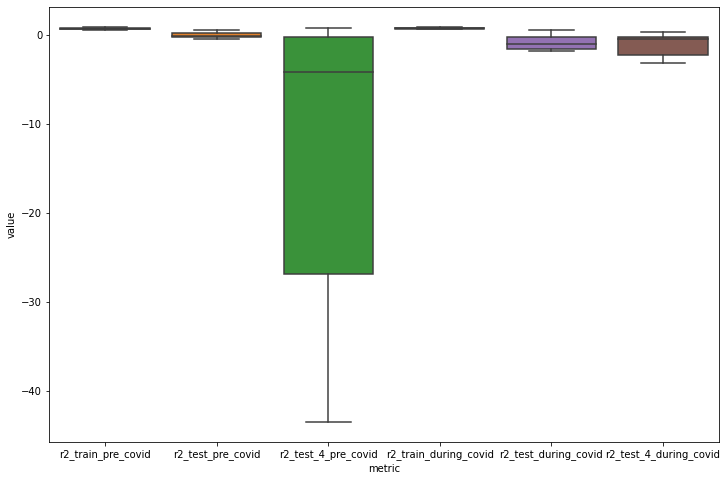

In [ ]:
boxplot_data_r2 = model_evaluation_df.drop(['sections', 
                                            'mape_train_pre_covid', 
                                            'mape_test_pre_covid',
                                            'mape_train_during_covid',
                                            'mape_test_during_covid',
                                            'mape_test_4_pre_covid',
                                            'mape_test_4_during_covid'
                                            ], axis = 1).stack().reset_index()
boxplot_data_r2.columns = ['section', 'metric', 'value']
fig, ax = plt.subplots(figsize = (12, 8))
sns.boxplot(y = 'value', x = 'metric', data = boxplot_data_r2, showfliers = False, ax = ax)

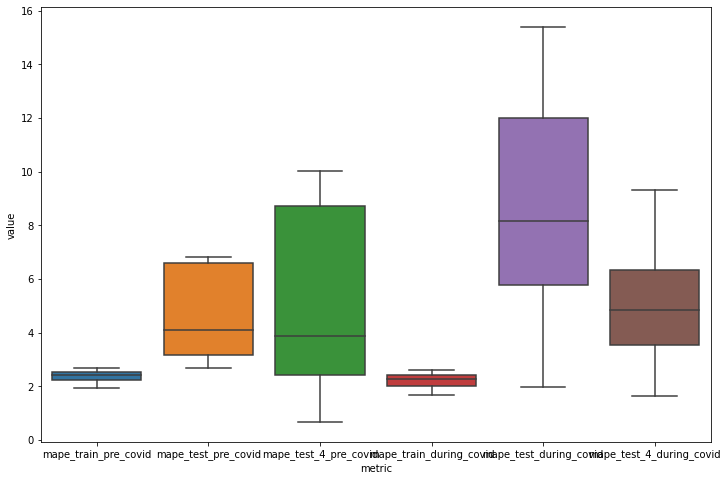

In [ ]:
boxplot_data_mape = model_evaluation_df.drop(['sections', 
                                              'r2_train_pre_covid', 
                                              'r2_test_pre_covid',
                                              'r2_train_during_covid',
                                              'r2_test_during_covid',
                                              'r2_test_4_pre_covid',
                                              'r2_test_4_during_covid'                                              
                                              ], axis = 1).stack().reset_index()
boxplot_data_mape.columns = ['section', 'metric', 'value']
fig, ax = plt.subplots(figsize = (12, 8))
sns.boxplot(y = 'value', x = 'metric', data = boxplot_data_mape, showfliers = False, ax = ax)